In [1]:
import matplotlib.pyplot as plt
import torch
import kagglehub
import os
import torch.nn as nn
import torchvision.models as models
from torchinfo import summary
from torch import optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore")

c:\Users\panda\OneDrive\Documents\Coding_Stuff\Computer Vision\venv_py311_cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I did not implemented wandb here because I do not want to 😂😜😜

# Dataset_Preparation and Sampling

In [2]:
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

# Hyperparameters
batch_size = 16
learning_rate = 0.01
num_epochs = 15
image_size = 224

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset_path = os.path.join(path, "flowers")
dataset = ImageFolder(root=dataset_path, transform=transform)

In [3]:
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Training start

In [4]:
import timm
import re
nasnet_model = timm.create_model('nasnetalarge', pretrained=True, num_classes=5)

In [5]:
class NasNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.base_model = timm.create_model('nasnetalarge', pretrained=True, num_classes=num_classes)
    def forward(self, x):
        x = self.base_model(x)
        return x

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NasNet().to(device)
trainable_patterns = [
    r"last_linear\.",
    r"cell_1[5-7]\.",        # example: last few cells
    r"reduction_cell_1\."
]
for name, param in model.named_parameters():
    param.requires_grad = any(re.search(p, name) for p in trainable_patterns)
summary(model)  # Great way to look overall what is happening inside your model

Layer (type:depth-idx)                        Param #
NasNet                                        --
├─NASNetALarge: 1-1                           --
│    └─ConvNormAct: 2-1                       --
│    │    └─Conv2d: 3-1                       (2,592)
│    │    └─BatchNormAct2d: 3-2               (192)
│    └─CellStem0: 2-2                         --
│    │    └─ActConvBn: 3-3                    (4,116)
│    │    └─BranchSeparables: 3-4             (5,796)
│    │    └─BranchSeparables: 3-5             (12,726)
│    │    └─MaxPool2dSame: 3-6                --
│    │    └─BranchSeparables: 3-7             (12,726)
│    │    └─AvgPool2dSame: 3-8                --
│    │    └─BranchSeparables: 3-9             (9,414)
│    │    └─AvgPool2d: 3-10                   --
│    │    └─BranchSeparables: 3-11            (4,452)
│    │    └─MaxPool2dSame: 3-12               --
│    └─CellStem1: 2-3                         --
│    │    └─ActConvBn: 3-13                   (14,280)
│    │    └─ReLU: 

## Correct and optimised training loop

In [7]:
criterion = nn.CrossEntropyLoss()
# Only optimize parameters that require gradients (e.g., the classifier/head)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
training_accuracy = []
validation_accuracy = []
# Training loop
for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_dataset:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    avg_loss = running_loss / len(train_dataset) if len(train_dataset) > 0 else 0.0
    train_acc = correct_train / total_train if total_train > 0 else 0.0
    
    loss_values.append(avg_loss)
    training_accuracy.append(train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_dataset:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_acc = correct_val / total_val if total_val > 0 else 0.0
    validation_accuracy.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/15] | Loss: 1.0845 | Train Acc: 0.7305 | Val Acc: 0.8469
Epoch [2/15] | Loss: 0.4394 | Train Acc: 0.8636 | Val Acc: 0.9118
Epoch [3/15] | Loss: 0.2739 | Train Acc: 0.9088 | Val Acc: 0.9095
Epoch [4/15] | Loss: 0.1871 | Train Acc: 0.9346 | Val Acc: 0.9049
Epoch [5/15] | Loss: 0.2197 | Train Acc: 0.9438 | Val Acc: 0.8561
Epoch [6/15] | Loss: 0.2018 | Train Acc: 0.9418 | Val Acc: 0.9026
Epoch [7/15] | Loss: 0.1328 | Train Acc: 0.9603 | Val Acc: 0.9002
Epoch [8/15] | Loss: 0.0975 | Train Acc: 0.9734 | Val Acc: 0.8701
Epoch [9/15] | Loss: 0.0913 | Train Acc: 0.9751 | Val Acc: 0.9072
Epoch [10/15] | Loss: 0.0780 | Train Acc: 0.9789 | Val Acc: 0.8840
Epoch [11/15] | Loss: 0.0582 | Train Acc: 0.9806 | Val Acc: 0.9072
Epoch [12/15] | Loss: 0.0566 | Train Acc: 0.9809 | Val Acc: 0.9118
Epoch [13/15] | Loss: 0.0421 | Train Acc: 0.9864 | Val Acc: 0.9026
Epoch [14/15] | Loss: 0.0476 | Train Acc: 0.9849 | Val Acc: 0.8840
Epoch [15/15] | Loss: 0.0643 | Train Acc: 0.9838 | Val Acc: 0.8910


See after unfreezing some of the last layers of the architecture we can alearly see that the trainingaccuracy and validation accuracy whops to so large values this is because we are increasing the size of learnable parameters to a lot of 24 million from just 20k

Last results

Epoch [1/15] | Loss: 1.3211 | Train Acc: 0.7319 | Val Acc: 0.8097

Epoch [2/15] | Loss: 0.7332 | Train Acc: 0.8324 | Val Acc: 0.8306

Epoch [3/15] | Loss: 0.6933 | Train Acc: 0.8541 | Val Acc: 0.8144

Epoch [4/15] | Loss: 0.8503 | Train Acc: 0.8411 | Val Acc: 0.8121

Epoch [5/15] | Loss: 0.8074 | Train Acc: 0.8497 | Val Acc: 0.8121

Epoch [6/15] | Loss: 0.7167 | Train Acc: 0.8749 | Val Acc: 0.8121

Epoch [7/15] | Loss: 0.7172 | Train Acc: 0.8819 | Val Acc: 0.8469

Epoch [8/15] | Loss: 0.5005 | Train Acc: 0.8998 | Val Acc: 0.8121

Epoch [9/15] | Loss: 0.5579 | Train Acc: 0.8981 | Val Acc: 0.8144

Epoch [10/15] | Loss: 0.6602 | Train Acc: 0.8891 | Val Acc: 0.7981

Epoch [11/15] | Loss: 0.5940 | Train Acc: 0.9010 | Val Acc: 0.8051

Epoch [12/15] | Loss: 0.6043 | Train Acc: 0.8964 | Val Acc: 0.8329

Epoch [13/15] | Loss: 0.5662 | Train Acc: 0.9047 | Val Acc: 0.8237

Epoch [14/15] | Loss: 0.4218 | Train Acc: 0.9172 | Val Acc: 0.8051

Epoch [15/15] | Loss: 0.4276 | Train Acc: 0.9279 | Val Acc: 0.8121



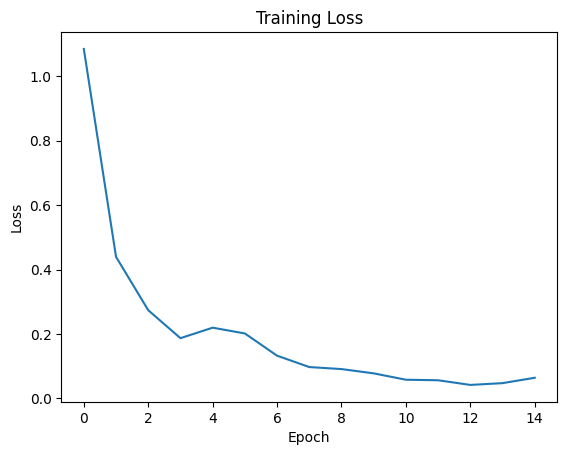

In [12]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

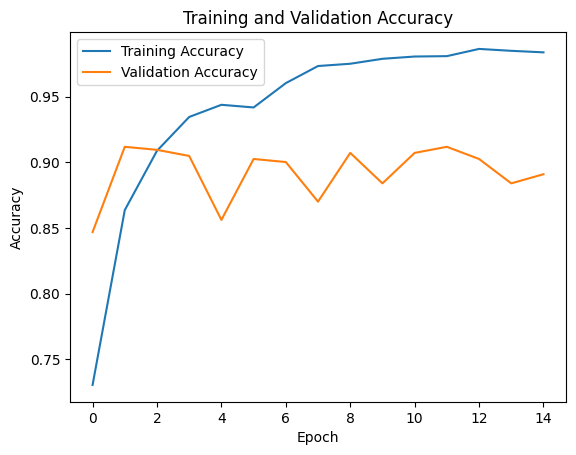

In [13]:
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Test

In [ ]:
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
  for images, labels in test_dataset:
    images, labels = images.to(device), labels.to(device)
    y_eval = model(images)
    _, predicted = torch.max(y_eval, 1)
    correct_test += (predicted==labels).sum().item()  # .item() converts tensor value to single value scalar
    total_test += len(labels)
  test_accuracy = correct_test/total_test

print(f"Overall test Accuracy: {test_accuracy:.4f}")
print(f"Final train Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final validation Accuracy: {validation_accuracy[-1]:.4f}")

Testing can not be done beacause of some issues but it can be clearly said that the accuracy will surely go upto 90-92%